# Image Captioning avec RNN et Attention sur ResNet

In [1]:
!pip install -q gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 43.0 MB/s eta 0:00:00


In [32]:
import os
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from collections import Counter
from tqdm import tqdm
from datasets import load_dataset
import gensim.downloader as api
import matplotlib.pyplot as plt

## CONFIGURATION & DEVICE

In [74]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_dim = 300
hidden_dim = 512
attention_dim = 512
batch_size = 64  # Augmenté pour stabiliser le gradient
learning_rate = 3e-4 # Learning rate plus conservateur pour LSTM
num_epochs = 6

## PRÉPARATION DATASET & VOCAB

In [34]:
print("⏳ Chargement du dataset Flickr30k...")
ds = load_dataset("lmms-lab/flickr30k", split='test') # Utilisation du split test

splits = ds.train_test_split(test_size=0.15, seed=42)
train_hf = splits['train']
test_hf = splits['test']

print("⏳ Chargement de Word2Vec...")
word_vectors = api.load("word2vec-google-news-300")

# Construction du vocabulaire
SPECIAL_TOKENS = ["<pad>", "<sos>", "<eos>", "<unk>"]
counter = Counter()

print("🔨 Construction du vocabulaire...")
for item in tqdm(train_hf):
    for cap in item["caption"]:
        counter.update(cap.lower().split())

# On ne garde que les mots qui apparaissent au moins 3 fois pour réduire le bruit
vocab_words = {w for w, c in counter.items() if c >= 3}
idx2word = SPECIAL_TOKENS + list(vocab_words)
word2idx = {w: i for i, w in enumerate(idx2word)}

print(f"✅ Taille du vocabulaire : {len(idx2word)}")

# Création de la matrice d'embeddings
embedding_matrix = np.zeros((len(idx2word), embed_dim))
for i, word in enumerate(idx2word):
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]
    else:
        # Init aléatoire plus petite (scale=0.1) pour ne pas exploser les gradients
        embedding_matrix[i] = np.random.normal(scale=0.1, size=(embed_dim,))

embedding_layer = nn.Embedding(len(idx2word), embed_dim)
embedding_layer.weight.data.copy_(torch.from_numpy(embedding_matrix))
# On gèle Word2Vec pour le début, on pourra le dégeler plus tard si besoin
embedding_layer.weight.requires_grad = False

⏳ Chargement du dataset Flickr30k...
⏳ Chargement de Word2Vec...
🔨 Construction du vocabulaire...


100%|██████████| 27015/27015 [02:07<00:00, 211.74it/s]


✅ Taille du vocabulaire : 9417


## DATASET CLASS

In [35]:
class Flickr30kDataset(Dataset):
    def __init__(self, hf_dataset, word2idx, transform=None, max_len=25):
        self.dataset = hf_dataset
        self.word2idx = word2idx
        self.transform = transform
        self.max_len = max_len
        self.ids = list(range(len(hf_dataset)))

    def tokenize(self, caption):
        tokens = [self.word2idx["<sos>"]]
        for w in caption.lower().split():
            tokens.append(self.word2idx.get(w, self.word2idx["<unk>"]))
        tokens.append(self.word2idx["<eos>"])

        # Padding / Truncation
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
            tokens[-1] = self.word2idx["<eos>"]
        else:
            tokens += [self.word2idx["<pad>"]] * (self.max_len - len(tokens))
        return torch.tensor(tokens, dtype=torch.long)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        # On prend une caption au hasard parmi les 5 disponibles pour varier l'entraînement
        caption = np.random.choice(item["caption"])

        if self.transform:
            image = self.transform(image)

        tokens = self.tokenize(caption)
        return image, tokens

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

train_dataset = Flickr30kDataset(train_hf, word2idx, transform)
test_dataset = Flickr30kDataset(test_hf, word2idx, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

## MODÈLES

In [71]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # On garde tout sauf les 2 dernières couches (AvgPool et FC)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])

        # Fine-tuning : on gèle tout
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        # Out: (Batch, 2048, 7, 7)
        features = self.resnet(images)
        # On aplatit spatialement : (Batch, 2048, 49) -> (Batch, 49, 2048)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, features.size(-1))
        return features

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        # encoder_out: (Batch, 49, 2048)
        # decoder_hidden: (Batch, 512)

        att1 = self.encoder_att(encoder_out)      # (Batch, 49, att_dim)
        att2 = self.decoder_att(decoder_hidden)   # (Batch, att_dim)

        # Broadcast addition
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (Batch, 49)
        alpha = self.softmax(att)                 # (Batch, 49)

        # Context vector : somme pondérée des features
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1) # (Batch, 2048)

        return attention_weighted_encoding, alpha

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, encoder_dim, attention_dim, embedding_layer):
        super(DecoderLSTM, self).__init__()

        self.vocab_size = vocab_size
        self.encoder_dim = encoder_dim
        self.hidden_dim = hidden_dim

        self.embedding = embedding_layer
        self.attention = Attention(encoder_dim, hidden_dim, attention_dim)

        # ⚠️ FIX "a a a a": Initialisation Gate
        self.init_h = nn.Linear(encoder_dim, hidden_dim)
        self.init_c = nn.Linear(encoder_dim, hidden_dim)

        # LSTM Gate (Manuelle)
        # Input gate prend : [Embedding + Context + Hidden_prev]
        input_dim = embed_dim + encoder_dim + hidden_dim

        self.W_i = nn.Linear(input_dim, hidden_dim)
        self.W_f = nn.Linear(input_dim, hidden_dim) # Forget
        self.W_c = nn.Linear(input_dim, hidden_dim) # Cell update
        self.W_o = nn.Linear(input_dim, hidden_dim) # Output

        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.5)

        self.init_weights()

    def init_weights(self):
        # Initialisation du biais du Forget Gate à 1 pour éviter l'oubli instantané
        self.W_f.bias.data.fill_(1.0)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        # (Batch, 49, 2048) -> Mean -> (Batch, 2048)
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out) # (Batch, hidden_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward_step(self, xt, h_prev, c_prev, encoder_out):
        # 1. Calcul Attention
        context, alpha = self.attention(encoder_out, h_prev)

        # 2. Concaténation [Embed(xt), h_prev, Context]
        # Attention: dans ton code c'était [emb, h, att], c'est bon tant que les dims matchent
        concat_input = torch.cat([xt, h_prev, context], dim=1)

        # 3. Portes LSTM
        i_t = torch.sigmoid(self.W_i(concat_input))
        f_t = torch.sigmoid(self.W_f(concat_input))
        o_t = torch.sigmoid(self.W_o(concat_input))
        g_t = torch.tanh(self.W_c(concat_input))

        # 4. Update Etats
        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        # 5. Output Prediction
        output = self.fc(self.dropout(h_t))

        return output, h_t, c_t, alpha

    def forward(self, features, captions):
        # features: (Batch, 49, 2048)
        # captions: (Batch, max_len)

        batch_size = features.size(0)
        seq_len = captions.size(1) - 1 # On prédit jusqu'à max_len-1

        # Embeddings
        embeds = self.embedding(captions)

        # Init Hidden avec l'image (CRUCIAL POUR EVITER "a a a")
        h, c = self.init_hidden_state(features)

        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).to(features.device)

        # Teacher Forcing loop
        for t in range(seq_len):
            # Input au temps t
            xt = embeds[:, t, :]

            output, h, c, _ = self.forward_step(xt, h, c, features)
            outputs[:, t, :] = output

        return outputs

    def generate_caption(self, features, max_len=20, vocab=None):
        # Inference mode (Greedy Search)
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)

        word_idx = vocab["<sos>"]
        start_token = torch.tensor(word_idx).to(features.device).view(1) # (1)

        captions = []

        # Premier embedding
        xt = self.embedding(start_token) # (1, embed_dim)

        for t in range(max_len):
            output, h, c, _ = self.forward_step(xt, h, c, features)

            predicted_idx = output.argmax(1) # Greedy

            if predicted_idx.item() == vocab["<eos>"]:
                break

            captions.append(predicted_idx.item())

            # Next input is the predicted word
            xt = self.embedding(predicted_idx)

        return captions

## TRAINING SETUP

In [72]:
encoder = EncoderCNN().to(DEVICE)
decoder = DecoderLSTM(
    vocab_size=len(idx2word),
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    encoder_dim=2048,
    attention_dim=attention_dim,
    embedding_layer=embedding_layer
).to(DEVICE)

# Loss : Ignore le padding
criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<pad>"])

# Optimiseur : Seulement params décodeur (Encoder est gelé)
optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

In [73]:
def save_model(epoch):
    state = {
        'epoch': epoch,
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict(),
        'optimizer': optimizer.state_dict(),
        'word2idx': word2idx
    }
    torch.save(state, "model_checkpoint_.pth")

## BOUCLE D'ENTRAÎNEMENT

In [75]:
print("\n🚀 Démarrage de l'entraînement...")

for epoch in range(num_epochs):
    encoder.eval() # Toujours eval pour BatchNorm gelé
    decoder.train()

    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, captions in progress_bar:
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        # Zero grad
        optimizer.zero_grad()

        # Forward
        with torch.no_grad():
            features = encoder(images)

        outputs = decoder(features, captions)

        # Targets : decale de 1 (on prédit le mot suivant)
        targets = captions[:, 1:]

        # Reshape pour CrossEntropy : (Batch * Seq, Vocab) vs (Batch * Seq)
        loss = criterion(outputs.view(-1, len(idx2word)), targets.reshape(-1))

        # Backward
        loss.backward()

        # Clip gradient (Important pour LSTM)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5.0)

        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Loss Moyenne: {avg_loss:.4f}")

    # --- TEST RAPIDE ---
    decoder.eval()
    with torch.no_grad():
        test_img, test_cap = test_dataset[0] # Prendre une image du set de test
        test_img_tensor = test_img.unsqueeze(0).to(DEVICE)
        features = encoder(test_img_tensor)

        pred_indices = decoder.generate_caption(features, vocab=word2idx)

        generated_sent = " ".join([idx2word[i] for i in pred_indices])
        ground_truth = " ".join([idx2word[i] for i in test_cap.tolist() if i not in [word2idx["<pad>"], word2idx["<sos>"], word2idx["<eos>"]]])

        print(f"🖼️ GT : {ground_truth}")
        print(f"🤖 Gen: {generated_sent}")
        print("-" * 50)

    save_model(epoch)

print("✅ Entraînement terminé.")


🚀 Démarrage de l'entraînement...


Epoch 1/6: 100%|██████████| 423/423 [03:46<00:00,  1.87it/s, loss=4.56]


Epoch 1 - Loss Moyenne: 4.9409
🖼️ GT : tall man in red and black stands outside holding basketball .
🤖 Gen: a man in a black shirt is a black shirt is on a red shirt and a white shirt and
--------------------------------------------------


Epoch 2/6: 100%|██████████| 423/423 [03:45<00:00,  1.88it/s, loss=3.56]


Epoch 2 - Loss Moyenne: 4.0769
🖼️ GT : a young adult male stands with a basketball on a court .
🤖 Gen: a man in a blue shirt and a blue shirt and a blue shirt and a blue shirt and a
--------------------------------------------------


Epoch 3/6: 100%|██████████| 423/423 [03:45<00:00,  1.88it/s, loss=3.59]


Epoch 3 - Loss Moyenne: 3.7753
🖼️ GT : a young adult male stands with a basketball on a court .
🤖 Gen: a man in a blue shirt and a black shirt is walking down a sidewalk .
--------------------------------------------------


Epoch 4/6: 100%|██████████| 423/423 [03:42<00:00,  1.90it/s, loss=2.61]


Epoch 4 - Loss Moyenne: 3.6042
🖼️ GT : guy holding a basketball wearing red shirt black shorts with something on left leg
🤖 Gen: a man in a red shirt is walking down a sidewalk .
--------------------------------------------------


Epoch 5/6: 100%|██████████| 423/423 [03:43<00:00,  1.89it/s, loss=3.35]


Epoch 5 - Loss Moyenne: 3.4697
🖼️ GT : the man with the red shirt is holding a basketball and is in front of a basketball hoop .
🤖 Gen: a man in a blue shirt and a blue shirt is walking down a sidewalk .
--------------------------------------------------


Epoch 6/6: 100%|██████████| 423/423 [03:44<00:00,  1.88it/s, loss=2.75]


Epoch 6 - Loss Moyenne: 3.3707
🖼️ GT : a young adult male stands with a basketball on a court .
🤖 Gen: a man in a red shirt and a red shirt is walking down a sidewalk .
--------------------------------------------------
✅ Entraînement terminé.


## TESTS

In [76]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def predict_single_image(image_path_or_url):
    """
    Charge une image, la transforme et prédit la légende avec le modèle actuel.
    """
    # 1. Chargement de l'image
    try:
        if image_path_or_url.startswith('http'):
            response = requests.get(image_path_or_url)
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(image_path_or_url).convert('RGB')
    except Exception as e:
        print(f"Erreur lors du chargement de l'image : {e}")
        return

    # 2. Prétraitement (Mêmes transforms que l'entraînement)
    # img_tensor shape: (1, 3, 224, 224)
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # 3. Inférence
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        # Extraction des features
        features = encoder(img_tensor)

        # Génération (méthode greedy définie dans ton DecoderLSTM)
        pred_indices = decoder.generate_caption(features, vocab=word2idx)

    # 4. Décodage des indices en mots
    sentence = []
    for idx in pred_indices:
        word = idx2word[idx]
        if word == "<eos>":
            break
        sentence.append(word)

    generated_text = " ".join(sentence)

    # 5. Affichage
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Prediction: {generated_text}", fontsize=12, color='blue', wrap=True)
    plt.axis('off')
    plt.show()

    return generated_text

Test URL: https://img.freepik.com/free-photo/dog-running-beach_1157-19430.jpg


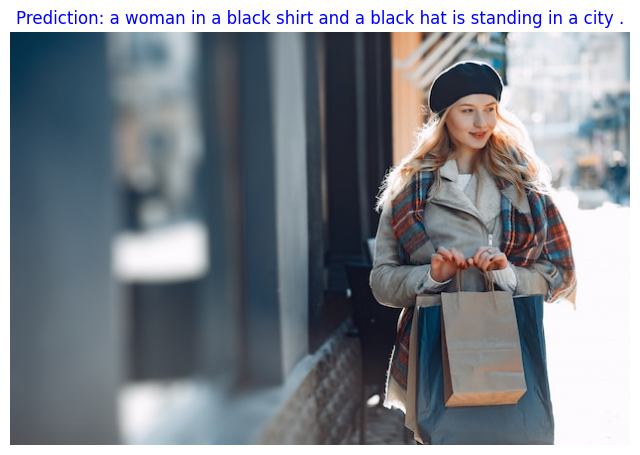

'a woman in a black shirt and a black hat is standing in a city .'

In [42]:
url_test = "https://img.freepik.com/free-photo/dog-running-beach_1157-19430.jpg"
print(f"Test URL: {url_test}")
predict_single_image(url_test)

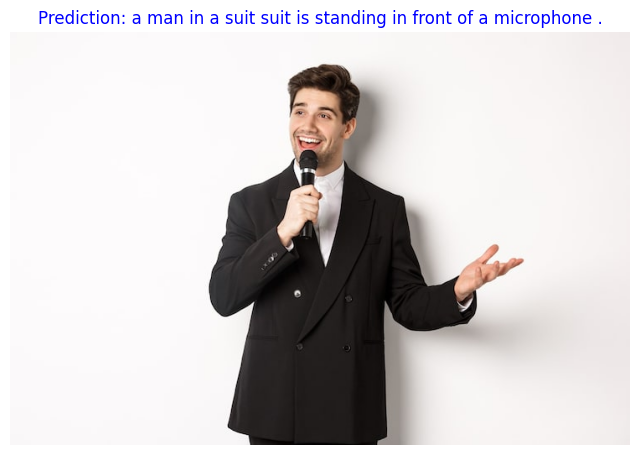

'a man in a suit suit is standing in front of a microphone .'

In [81]:
test_mic = "https://img.freepik.com/free-photo/portrait-handsome-man-black-suit-singing-song-holding-microphone-giving-speech-standing-against-white-background_1258-64790.jpg?semt=ais_hybrid&w=740&q=80"
predict_single_image(test_mic)

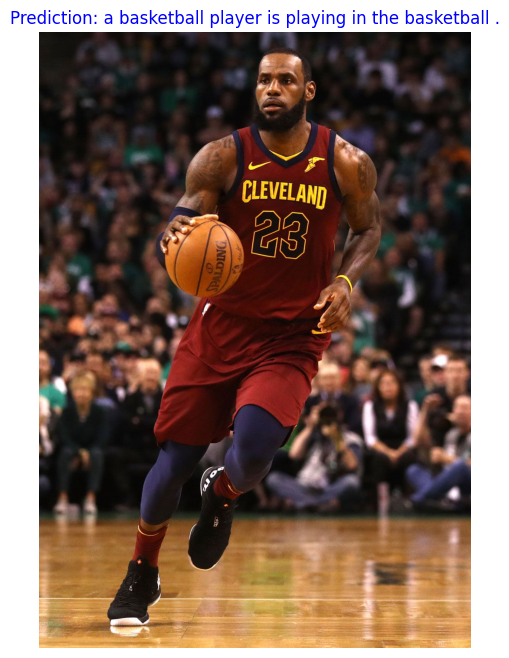

'a basketball player is playing in the basketball .'

In [79]:
url_basket = "https://cdn.britannica.com/82/212182-050-50D9F3CE/basketball-LeBron-James-Cleveland-Cavaliers-2018.jpg"
predict_single_image(url_basket)

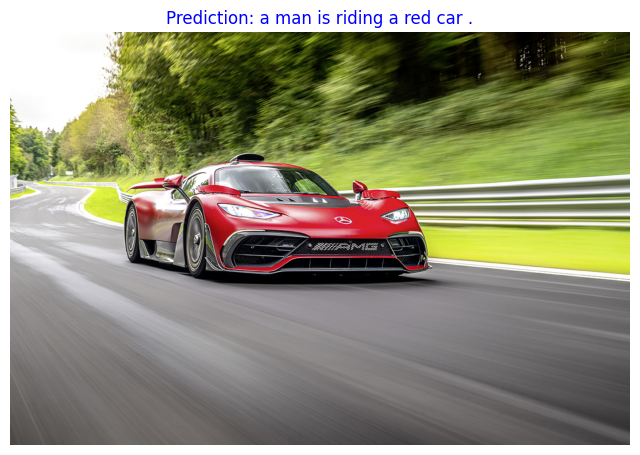

'a man is riding a red car .'

In [49]:
url_speed = "https://c02.purpledshub.com/uploads/sites/41/2025/03/Mercedes-Benz_AMG_ONE_Nordschleife_2024-3.jpg"
predict_single_image(url_speed)

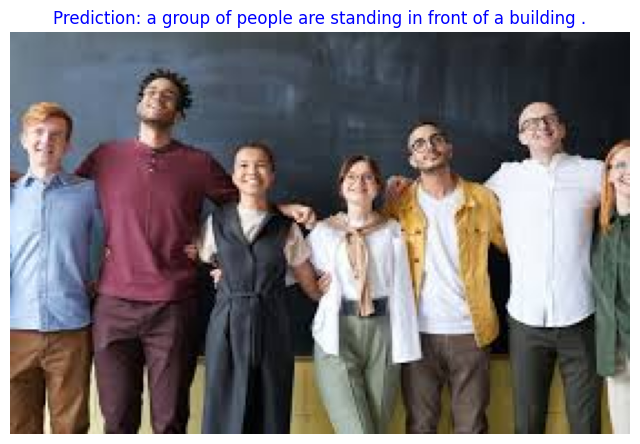

'a group of people are standing in front of a building .'

In [87]:
url_people = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQCUEgca46lAETpI4zUXh6TzVR0d-JaA0s9pA&s"
predict_single_image(url_people)

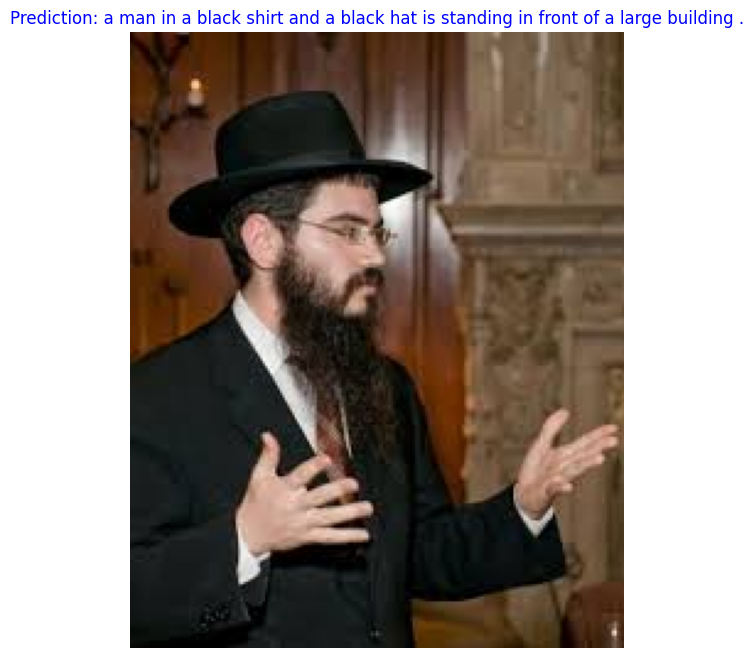

'a man in a black shirt and a black hat is standing in front of a large building .'

In [50]:
test = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSiY6zemz1Mw9M4PEQjPPfFs6Yzt3M-mJqFKA&s"
predict_single_image(test)

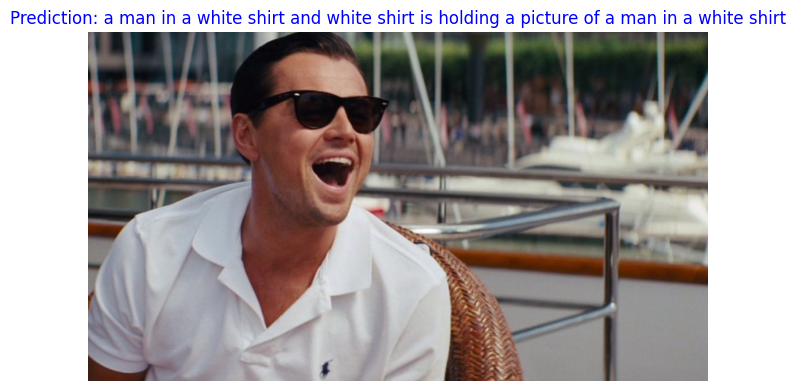

'a man in a white shirt and white shirt is holding a picture of a man in a white shirt'

In [55]:
test2 = "https://i0.wp.com/newspack-washingtoncitypaper.s3.amazonaws.com/uploads/2023/10/Wolf-of-Wall-Street.jpg?fit=780%2C439&quality=89&ssl=1"
predict_single_image(test2)